In [17]:
from pathlib import Path  
from matplotlib import pyplot as plot
from pathlib import Path  
import pandas as pandas
import numpy as numpy
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [18]:
dataframe = pandas.read_csv("dataset.csv").dropna()
feature_names = ["Appliances","T1","RH_1","T2","RH_2","T3","RH_3","T4","RH_4","T5","RH_5","T6","RH_6","T7","RH_7","T8","RH_8","T9","RH_9","T_out","Press_mm_hg","RH_out","Windspeed","Visibility","Tdewpoint"]
dataframe = dataframe[feature_names]

X = dataframe.drop("Appliances", axis = 1)
y = dataframe["Appliances"]
TEST_SIZE_RATIO = (1 / 3)
RANDOM_STATE_SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, random_state=RANDOM_STATE_SEED)

In [19]:
GBR_metrics_dataset_PATH = Path("./GBR_metrics_dataset.csv")
if not(GBR_metrics_dataset_PATH.exists() and GBR_metrics_dataset_PATH.is_file()):
    N_ESTIMATORS = 100
    MAX_DEPTH_SET = [1, 2, 3]
    gbr_metrics_dataframe = pandas.DataFrame(data = {"max_depth": [], "iteration": [], "training_loss": [], "root_mean_square_error": [], "r2_score": [], "mean_absolute_error": [], "mean_absolute_percentage_error": []})
    for max_depth_iterator in MAX_DEPTH_SET:
        print("Training Gradient Boosted Regression Model for MAX_DEPTH: %d" %max_depth_iterator)
        gradient_boosting_regressor = GradientBoostingRegressor(n_estimators = N_ESTIMATORS, max_depth = max_depth_iterator, verbose = 1)
        gradient_boosting_regressor.fit(X_train, y_train)
        for iteration, y_pred in enumerate(gradient_boosting_regressor.staged_predict(X)):
            temp_gbr_metrics = pandas.DataFrame(data = {"max_depth": [max_depth_iterator], "iteration": [iteration], "training_loss": [gradient_boosting_regressor.loss_(y, y_pred)], "root_mean_square_error": [mean_squared_error(y, y_pred, squared=False)], "r2_score": [r2_score(y, y_pred)], "mean_absolute_error": [mean_absolute_error(y, y_pred)], "mean_absolute_percentage_error": [mean_absolute_percentage_error(y, y_pred)]})
            gbr_metrics_dataframe.append(temp_gbr_metrics)
    gbr_metrics_dataframe.to_csv(GBR_metrics_dataset_PATH.name)

    GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH = Path("./GBR_releative_feature_importance_dataset.csv")
    feature_importance = gradient_boosting_regressor.feature_importances_
    releative_feature_importance = (feature_importance / feature_importance.max()) * 100
    sorted_indices=numpy.argsort(releative_feature_importance)
    pandas.DataFrame(data = {"feature_names": numpy.array(feature_names)[sorted_indices], "releative_feature_importance": releative_feature_importance[sorted_indices], "feature_importance": feature_importance[sorted_indices]}).to_csv(GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH.name)


Training Gradient Boosted Regression Model for MAX_DEPTH: 1
      Iter       Train Loss   Remaining Time 
         1       10489.5386            2.46s
         2       10450.7376            2.47s
         3       10419.3088            2.44s
         4       10391.1226            2.40s
         5       10365.7311            2.37s
         6       10344.3734            2.34s
         7       10323.5500            2.31s
         8       10304.3883            2.29s
         9       10286.5598            2.26s
        10       10269.6979            2.24s
        20       10133.3963            1.97s
        30       10037.7359            1.72s
        40        9959.4346            1.47s
        50        9891.3821            1.23s
        60        9830.9951            0.98s
        70        9775.0576            0.75s
        80        9723.6733            0.52s
        90        9675.5107            0.26s
       100        9631.0072            0.00s
Training Gradient Boosted Regression Mo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


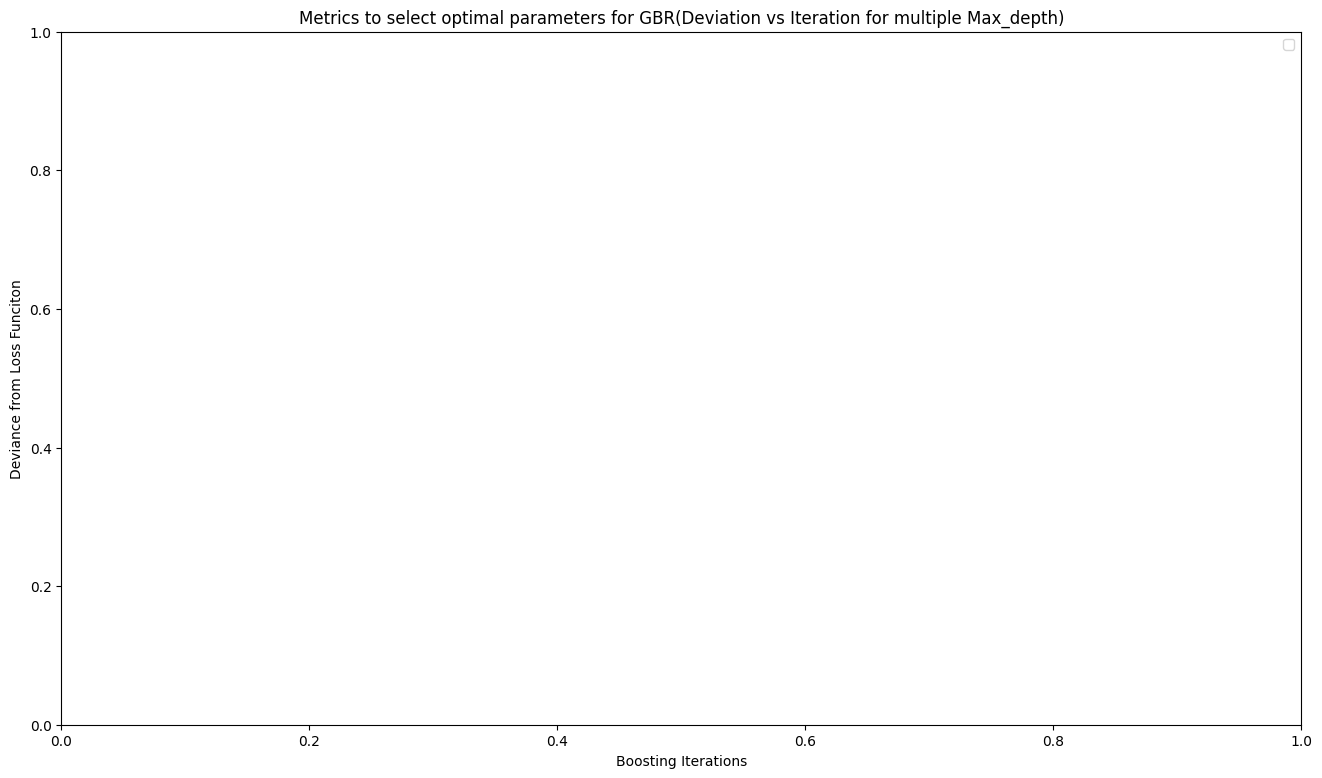

In [20]:
gbr_metrics = pandas.read_csv(GBR_metrics_dataset_PATH.name)
plot.figure(figsize=(16,9))
plot.xlabel('Boosting Iterations')
plot.ylabel('Deviance from Loss Funciton')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot.plot(performance["iteration"], performance["training_loss"], label = "max_depth: "  + str(depth))
plot.legend(loc='upper right')
plot.title("Metrics to select optimal parameters for GBR(Deviation vs Iteration for multiple Max_depth)")
plot.savefig("GBR_deviation_vs_iteration_for_multiple_max_depth.png")
plot.show()

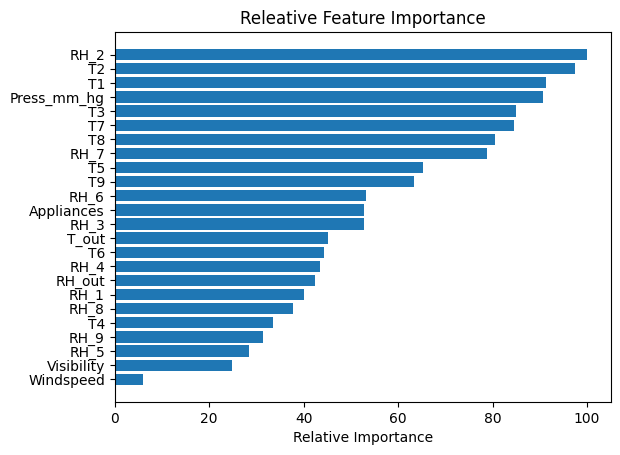

<Figure size 1600x900 with 0 Axes>

In [21]:
# Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
feature_importance = gradient_boosting_regressor.feature_importances_
releative_feature_importance = (feature_importance / feature_importance.max()) * 100
sorted_indices=numpy.argsort(releative_feature_importance)
pos=numpy.arange(sorted_indices.shape[0])
plot.barh(pos, releative_feature_importance[sorted_indices], align="center")
plot.yticks(pos, numpy.array(feature_names)[sorted_indices])
plot.xlabel('Relative Importance')
plot.title('Releative Feature Importance')
plot.figure(figsize=(16, 9))
plot.show()